Imports

In [ ]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (           
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix
)
warnings.filterwarnings('ignore')

1. Load the data

In [31]:
X_train = np.load('artifacts/X_train.npz')['arr_0']
Y_train = np.load('artifacts/Y_train.npz')['arr_0']
X_test = np.load('artifacts/X_test.npz')['arr_0']
Y_test = np.load('artifacts/Y_test.npz')['arr_0']

2. Configure K-Fold CV

In [32]:
cv = StratifiedKFold(
    n_splits=6,
    random_state=42,
    shuffle =True
)

In [33]:
model_lr = LogisticRegression(
    random_state=42,
    max_iter=1000
)


In [34]:
cv_results = cross_validate(
    model_lr,
    X_train,
    Y_train,
    cv=cv, 
    scoring='accuracy',
    return_train_score=True
)

In [35]:
cv_results

{'fit_time': array([0.07778287, 0.06436753, 0.11800456, 0.53846121, 0.08653903,
        0.09634185]),
 'score_time': array([0.00700116, 0.00800657, 0.01107097, 0.00500131, 0.02498841,
        0.01090145]),
 'test_score': array([0.73863636, 0.71070076, 0.73188063, 0.7408811 , 0.72666982,
        0.73519659]),
 'train_score': array([0.7301061 , 0.73503221, 0.73003694, 0.72937388, 0.7338259 ,
        0.7294686 ])}

In [36]:
score_arr = ['accuracy', 'precision', 'recall', 'f1']
for score in score_arr:
    cv_results = cross_validate(model_lr, X_train, Y_train,
                                cv=cv, scoring=score,
                                return_train_score=True)
    test_score = cv_results['test_score']
    print(f"{score}: {test_score}  →  mean={test_score.mean():.4f}, std={test_score.std():.4f}")

accuracy: [0.73863636 0.71070076 0.73188063 0.7408811  0.72666982 0.73519659]  →  mean=0.7307, std=0.0100
precision: [0.74       0.70813845 0.72829132 0.74098672 0.72488263 0.73030584]  →  mean=0.7288, std=0.0109
recall: [0.73579545 0.71685606 0.73933649 0.74028436 0.73106061 0.74621212]  →  mean=0.7349, std=0.0093
f1: [0.73789174 0.71247059 0.73377234 0.74063537 0.72795851 0.7381733 ]  →  mean=0.7318, std=0.0096


In [37]:
# Step 1: find which fold had the best validation score
best_index = np.argmax(cv_results['test_score'])

# Step 2: regenerate all fold index pairs
fold_indices = list(cv.split(X_train, Y_train))
best_train_idx, best_val_idx = fold_indices[best_index]   # renamed to 'val' for clarity

# Step 3: sanity check
print(len(best_train_idx), len(best_val_idx))
print(max(best_val_idx), min(best_val_idx))

# Step 4: slice out the best fold's data (all from X_train since folds come from training data)
X_fold_train = X_train[best_train_idx]
Y_fold_train = Y_train[best_train_idx]
X_fold_val   = X_train[best_val_idx]
Y_fold_val   = Y_train[best_val_idx]

10557 2111
12665 11


In [38]:
model_lr = LogisticRegression(random_state=42, max_iter=1000)
model_lr.fit(X_fold_train, Y_fold_train)     # train on best fold's training portion

Y_hat_train = model_lr.predict(X_train)     # predictions on full training set
Y_hat_test  = model_lr.predict(X_test)      # predictions on held-out test set

In [39]:
accuracy   = accuracy_score(Y_test, Y_hat_test)
precision  = precision_score(Y_test, Y_hat_test)
recall     = recall_score(Y_test, Y_hat_test)
f1         = f1_score(Y_test, Y_hat_test)    # ← renamed variable to avoid shadowing

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

Accuracy:  0.6948
Precision: 0.3393
Recall:    0.6569
F1 Score:  0.4475


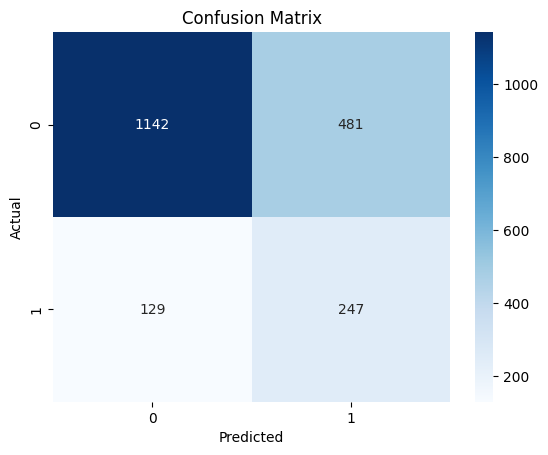

In [40]:
cm = confusion_matrix(Y_test, Y_hat_test)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()